In [1]:
!gdown --id 1fZBi823SFyyyzGm6oUK80By7y0xIiQVv

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1fZBi823SFyyyzGm6oUK80By7y0xIiQVv
From (redirected): https://drive.google.com/uc?id=1fZBi823SFyyyzGm6oUK80By7y0xIiQVv&confirm=t&uuid=465ec627-368f-4867-975d-084ef2dd1b1b
To: /content/images.zip
100% 53.9M/53.9M [00:00<00:00, 72.3MB/s]


In [2]:
!pip install -q faiss-cpu
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 21.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-choi0cr9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-choi0cr9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cu

In [3]:
!unzip -q images.zip

In [4]:
!pip install -q translate
!pip install -q underthesea==1.3.5a3
!pip install -q underthesea[deep]
!pip install -q pyvi
!pip install -q langdetect
!pip install -q googletrans==3.1.0a0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.2/591.2 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 35.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2

In [5]:
import os
import torch
import clip
from PIL import Image
import faiss
import numpy as np
import json
import matplotlib.pyplot as plt
import math
import googletrans
import translate
import glob
import underthesea
from pyvi import ViUtils, ViTokenizer
from langdetect import detect

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = clip.load('ViT-B/32', device=device)
features = []
id2img_fps = {}
list_image = glob.glob("images/*.jpg")

# Đọc ảnh trong folder -> CLIP -> Embedding
for id, image_path in enumerate(list_image):
    id2img_fps[id] = image_path
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image).detach().cpu().numpy() # Lấy image embedding
        features.append(image_features) # Lưu embedding vào list

image_embeddings = np.concatenate(features) # list embedding

with open('image_path.json', 'w') as f:
    f.write(json.dumps(id2img_fps))

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 106MiB/s]


In [7]:
#indexing
index = faiss.IndexFlatL2(image_embeddings.shape[1])
index.add(image_embeddings)

In [8]:
a = faiss.write_index(index, 'faiss_normal_ViT.bin')

In [10]:
class Translation():
    def __init__(self, from_lang='vi', to_lang='en', mode='google'):
        # The class Translation is a wrapper for the two translation libraries, googletrans and translate.
        self.__mode = mode
        self.__from_lang = from_lang
        self.__to_lang = to_lang

        if mode in 'googletrans':
            self.translator = googletrans.Translator()
        elif mode in 'translate':
            self.translator = translate.Translator(from_lang=from_lang, to_lang=to_lang)

    def preprocessing(self, text):
        return text.lower()

    def __call__(self, text):
        text = self.preprocessing(text)
        return self.translator.translate(text) if self.__mode in 'translate'\
               else self.translator.translate(text, dest=self.__to_lang).text


In [11]:
class Text_Preprocessing():
    def __init__(self, stopwords_path='./dict/vietnamese-stopwords-dash.txt'):
        with open(stopwords_path, 'rb') as f:
            lines = f.readlines()
        self.stop_words = [line.decode('utf-8').replace('\n', '') for line in lines]

    def find_substring(self, string1, string2):

        match = SequenceMatcher(None, string1, string2, autojunk=False).find_longest_match(0, len(string1), 0, len(string2))
        return string1[match.a:match.a + match.size].strip()

    def remove_stopwords(self, text):

        text = ViTokenizer.tokenize(text)
        return ' '.join([word for word in text.split() if word not in self.stop_words])

    def lowercasing(self, text):
        return text.lower()

    def uppercasing(self, text):
        return text.upper()

    def add_accents(self, text):
        return ViUtils.add_accents(u"{text}".format(text))

    def remove_accents(self, text):
        return ViUtils.remove_accents(u"{text}".format(text))

    def sentence_segment(self, text):
        return underthesea.sent_tokenize(text)

    def text_norm(self, text):
        return underthesea.text_normalize(text)

    def text_classify(self, text):
        return underthesea.sentiment(text)

    def __call__(self, text):
        text = text.lowercasing(text)
        text = text.remove_stopwords(text)
        # text = self.remove_accents(text)
        # text = self.add_accents(text)
        text = self.text_norm(text)
        categories = self.text_classify(text)
        return text, categories

In [16]:
class Myfaiss:
    def __init__(self, bin_file : str,id2img_fps, device, model):
        self.index= self.load_bin_file(bin_file)
        self.id2img_fps= id2img_fps
        self.device= device
        self.model = model

    def load_bin_file(self, bin_file: str):
        return faiss.read_index(bin_file)

    def show_images(self, image_paths):
        fig = plt.figure(figsize=(15, 10))
        columns = int(math.sqrt(len(image_paths)))
        rows = int(np.ceil(len(image_paths)/columns))

        for i in range(1, columns*rows +1):
          img = plt.imread(image_paths[i - 1])
          ax = fig.add_subplot(rows, columns, i)
          ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

          plt.imshow(img)
          plt.axis("off")

        plt.show()

    def image_search(self, id_query, k, bin_file):

        query_feats = self.index.reconstruct(id_query).reshape(1,-1)

        scores, idx_image = self.index.search(query_feats, k=k)
        idx_image = idx_image.flatten()

        infos_query = list(map(self.id2img_fps.get, list(idx_image)))
        image_paths = [info for info in infos_query]


        return scores, idx_image, infos_query, image_paths

    def text_search(self, text, k):
        translater = Translation()
        if detect(text) == 'vi':
            text = translater(text)

        ###### TEXT FEATURES EXACTING ######
        text = clip.tokenize([text]).to(self.device)
        text_features = self.model.encode_text(text).cpu().detach().numpy().astype(np.float32)

        ###### SEARCHING #####
        scores, idx_image = self.index.search(text_features, k=k)
        idx_image = idx_image.flatten()

        ###### GET INFOS KEYFRAMES_ID ######
        infos_query = list(map(self.id2img_fps.get, list(idx_image)))
        image_paths = [info for info in infos_query]

        return scores, idx_image, infos_query, image_paths

In [18]:
bin_files = 'faiss_normal_ViT.bin'
faiss_test = Myfaiss(bin_files, id2img_fps, device, model)

In [19]:
text = 'chiếc vali màu đỏ'

scores, idx_image, infos_query, image_paths = faiss_test.text_search(text, k=9)

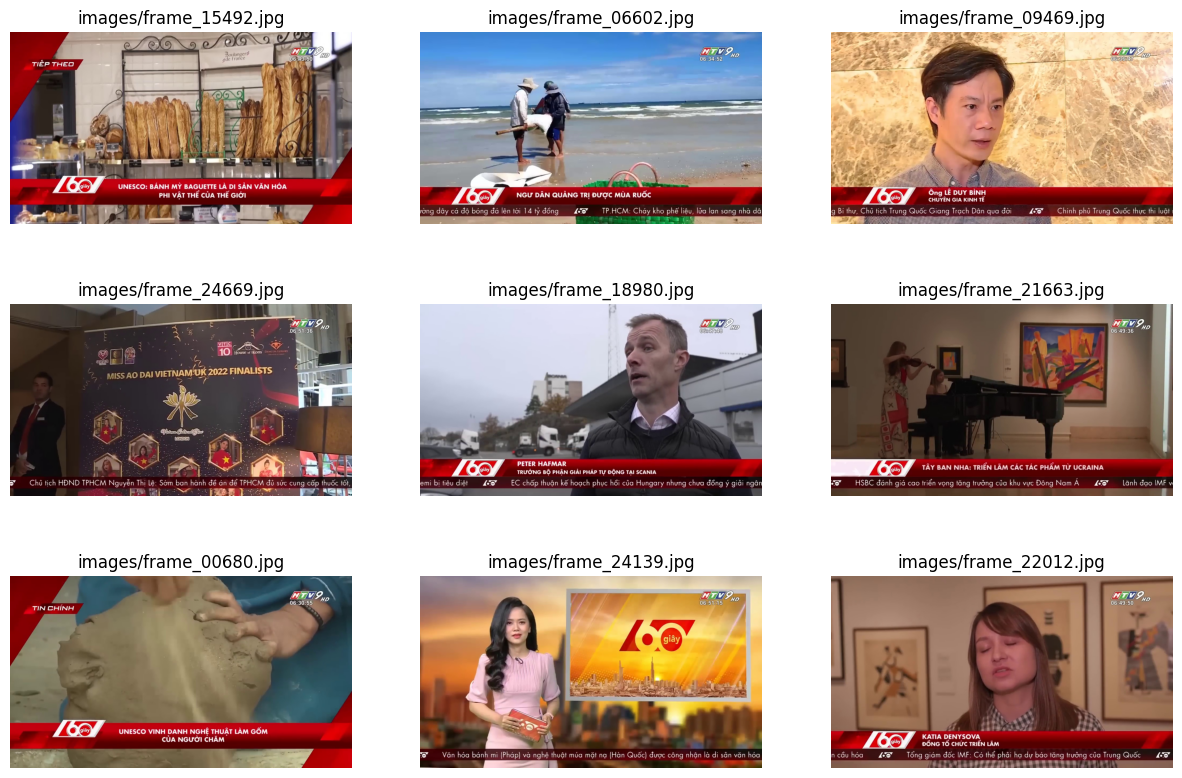

In [20]:
faiss_test.show_images(image_paths)